#Clasificador Naive Bayes
##Enlace colab: https://colab.research.google.com/drive/1mlt-AUGqdx0TANhJuvrm-0UgoWQq2ZpJ#scrollTo=aRMpnGs4RkCz



In [ ]:
!apt install golang-go

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  golang-1.10-go golang-1.10-race-detector-runtime golang-1.10-src
  golang-race-detector-runtime golang-src
Suggested packages:
  bzr mercurial subversion
The following NEW packages will be installed:
  golang-1.10-go golang-1.10-race-detector-runtime golang-1.10-src golang-go
  golang-race-detector-runtime golang-src
0 upgraded, 6 newly installed, 0 to remove and 12 not upgraded.
Need to get 40.3 MB of archives.
After this operation, 225 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 golang-1.10-src amd64 1.10.4-2ubuntu1~18.04.1 [11.1 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 golang-1.10-go amd64 1.10.4-2ubuntu1~18.04.1 [28.6 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 golang-1.10-race-detector-runtime amd64 0.0+svn285455-0ubuntu1 [478

In [ ]:
url="https://raw.githubusercontent.com/tropsmart18300/github_raw/main/test.csv"
!curl -0 $url

class,message
ham,"Hi, Mobile no.  &lt;#&gt;  has added you in their contact list on www.fullonsms.com It s a great place to send free sms to people For more visit fullonsms.com"
ham,Ok then u tell me wat time u coming later lor.
ham,U repeat e instructions again. Wat's e road name of ur house?
ham,"So many people seems to be special at first sight, But only very few will remain special to you till your last sight.. Maintain them till life ends.. Sh!jas"
ham,Quite lor. But dun tell him wait he get complacent...
ham,Sorry completely forgot * will pop em round this week if your still here?
ham,U R THE MOST BEAUTIFUL GIRL IVE EVER SEEN. U R MY BABY COME AND C ME IN THE COMMON ROOM
ham,O we cant see if we can join denis and mina? Or does denis want alone time
ham,Sen told that he is going to join his uncle finance in cbe
ham,"Yup... Hey then one day on fri we can ask miwa and jiayin take leave go karaoke "
ham,"Call me, i am senthil from hsbc."
ham,"Especially since i talk about boston all

#Lectura del dataset
##Luego de obtener las filas objetos del dataset se realiza lo siguiente:

###words: 
Obtener todas las palabras encontradas en el dataset

###unique:
Palabras unicas encontradas en el dataset

###spam:
Mensajes que pertenezcan a la clase spam

###ham:
Mensajes que pertenezcan a la clase ham


In [ ]:
%%writefile read_data.go
package main

import (
    "net/http"
    "io"
    "strings"
    "encoding/csv"
)

func ReadData() ([]string, []string, []string, []string, int) {
	url:="https://raw.githubusercontent.com/tropsmart18300/github_raw/main/test.csv"
	resp, _ := http.Get(url)

	defer resp.Body.Close()

	reader := csv.NewReader(resp.Body)

	var words []string
	var unique []string

	var hams []string
	var spams []string

	for {
		record, err := reader.Read()
		if err == io.EOF {
			break
		}
		message := strings.Split(record[1], " ")
		if record[0] == "spam" {
			spams = append(spams, record[1])
		} else {
			hams = append(hams, record[1])
		}

		for _, e := range message {
			word := NormalizeWord(string(e))
			words = append(words, word)
		}
	}

	for _, v := range words {
		skip := false
		for _, u := range unique {
			if v == u {
				skip = true
				break
			}
		}
		if !skip {
			unique = append(unique, v)
		}
	}

	totalMessages := len(spams) + len(hams)
	return words, unique, spams, hams, totalMessages
}


Writing read_data.go


##Para limipiar los datos de entrada se implementa un funcion normalizeWord, que generaliza cuando se detecta una cadena con informacion muy especifica, como fechas numeros de telefono, porcentajes, otros correos y enlaces a sitios web, 

In [ ]:
%%writefile clear_data.go

package main
import (
		"regexp"
)

func NormalizeWord(data string) string {
	b, _ := regexp.MatchString(data, "\\$[\\d]+")
	if b == true {
		return "price"
	}

	c, _ := regexp.MatchString(data, "\\%[\\d]+")
	if c == true {
		return "percentaje"
	}

	d, _ := regexp.MatchString(data, "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
	if d {
		return "link"
	}

	e, _ := regexp.MatchString(data, "(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\\.[a-zA-Z0-9-.]+$)")

	if e == true {
		return "email"
	}

	return data

}

Writing clear_data.go


#Ejecución del algoritmo
##Para el algoritmo se realizan los siguientes pasos:

Creacion de 2 maps, donde se lleanaran cada palabra encontrada en el input como key, y el valor inicial en 0

A esos diccionarios vamos a buscar la cantidads de palabra clave que hay en los mensajes de cada clase y se guardan las repeticiones del valor


Luego, al resultado obtenido en los diccionarios se le aplica la formula para obtener el valor porcentual de la palabra con respecto al total de palabras en el dataset siguiendo la formula:

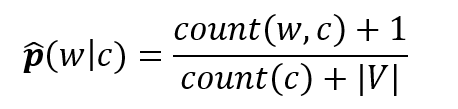


Siendo


*   w la palabra en el analizada
*   c la cantidad de palabras en el mensaje
*   V la cantidad de palabras en el dataset

Finalmente, se realiza la sumatoria de pesos del mensaje analizado en ambas listas de mensajes(spam y ham), multiplicando los porcentajes decimales obtenidos para cada mapa mas el valor porcentual del peso del la clase con respecto al total del dataset.
Para obtener el valor porcentual de la clase se sigue la formula

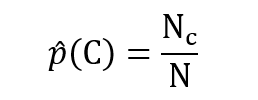

Siendo
*   N_c cantidad de mensajes de la clase
*   N total de mensajes en el dataset 

In [ ]:
%%writefile do_nn.go

package main

import(
    "fmt"
    "strings"
    "reflect"
)

func setWordWeights(wordsFoundClass map[string]float64, alpha float64, classOp []string, words []string, mainCh chan string, doneCh chan string) {
  for i, e := range wordsFoundClass {
		wordsFoundClass[i] = float64((e + alpha) / float64(float64(len(classOp))+float64(len(words))))
    mainCh <-fmt.Sprintf("Setting %d", i)
  }
  doneCh <- "Done"
}

func DoNaiveSpamHam(alpha float64, words []string, wordsSearch []string, spams []string, hams []string, priorSpam float64, priorHam float64, ch1 chan float64, ch2 chan float64) {
	fmt.Println("WORD SPAMS ==========================================================================")
  wordsFoundSpam := make(map[string]float64)
  fmt.Println("Type : ", reflect.TypeOf(wordsFoundSpam))
	//Fill data
	for i := range wordsSearch {
		wordsFoundSpam[wordsSearch[i]] = 0.0
	}
	//Search on spam list
	for _, e := range spams {
		for i := range wordsSearch {
			if strings.Contains(e, wordsSearch[i]) {
				wordsFoundSpam[wordsSearch[i]] += 1.0
			}
		}
	}

	fmt.Println("WORD HAMS ==========================================================================")
	wordsFoundHam := make(map[string]float64)
	for h := range wordsSearch {
		wordsFoundHam[wordsSearch[h]] = 0.0
	}

	//Search on ham list
	for _, e := range hams {
		for i := range wordsSearch {
			if strings.Contains(e, wordsSearch[i]) {
				wordsFoundHam[wordsSearch[i]] += 1.0
			}
		}
	}

  //==============================================================================================================

  chSpam := make(chan string)
  chEndSpam := make(chan string)
  chHam := make(chan string)
  chEndHam := make(chan string)

  go setWordWeights(wordsFoundSpam, alpha, spams, words, chSpam, chEndSpam)
  go setWordWeights(wordsFoundHam, alpha, hams, words, chHam, chEndHam)

  s := len(wordsFoundSpam) *2
  fmt.Println("values form : ", )

  for i := 0; i < s; i++ {
        select {
        case msg1 := <-chSpam:
            fmt.Printf("Running clean spam %s\n", msg1)
        case msg2 := <-chHam:
            fmt.Printf("\t\t\tRunning clean ham %s\n", msg2)
        }
    }
  
	finishSpam := <-chEndSpam
	finishHam := <-chEndHam
  fmt.Println("Spam ",finishSpam)
  fmt.Println("Ham ",finishHam)

  //==============================================================================================================

  weightMessageSpam := priorSpam
	for _, e := range wordsFoundSpam {
		weightMessageSpam *= float64(e)
	}

	ch1 <- weightMessageSpam

	weightMessageHam := priorHam
	for _, e := range wordsFoundHam {
		weightMessageHam *= float64(e)
	}

	ch2 <- weightMessageHam

}



Overwriting do_nn.go


#Algoritmo Naive Bayes

In [ ]:
%%writefile main.go
package main

import (
	"bufio"
	"fmt"
	"os"
	"strings"
)

func main() {
	words, unique, spams, hams, totalMessages := ReadData()

	fmt.Println("unique words size : ", len(unique))
	fmt.Println("words size : ", len(words))
	fmt.Println("spams : ", len(spams))
	fmt.Println("hams : ", len(hams))
	fmt.Println("total : ", totalMessages)

	reader := bufio.NewReader(os.Stdin)
	fmt.Print("Enter text: ")
	text, _ := reader.ReadString('\n')
	naiveBayes(text, spams, hams, words)
}



func naiveBayes(data string, spams []string, hams []string, words []string) {
	alpha := 0.00001
	priorSpam := float64(float64(len(spams)) / float64(len(spams)+len(hams)))
	priorHam := float64(float64(len(hams)) / float64(len(hams)+len(spams)))

	wordsSearch := strings.Split(data, " ")

	ch1 := make(chan float64)
	ch2 := make(chan float64)

  go DoNaiveSpamHam(alpha, words, wordsSearch, spams, hams, priorSpam, priorHam, ch1, ch2)
	//go DoNaiveHam(alpha, words, wordsSearch, hams, priorHam, ch1)
	//go DoNaiveSpam(alpha, words, wordsSearch, spams, priorSpam, ch2)

	weightMessageHam := <-ch1
	weightMessageSpam := <-ch2
	fmt.Println("weight ham : ", weightMessageHam)
	fmt.Println("weigth spam : ", weightMessageSpam)

	if weightMessageHam > weightMessageSpam {
		fmt.Println("Its ham")
	} else {
		fmt.Println("Its spam")
	}

}

Overwriting main.go


In [ ]:
!go run *.go

unique words size :  6969
words size :  27746
spams :  747
hams :  698
total :  1445
Enter text: setting down and forever
WORD SPAMS ==========================================================================
Type :  map[string]float64
WORD HAMS ==========================================================================
values form : 
			Running clean ham Setting %!d(string=forever
)
			Running clean ham Setting %!d(string=setting)
			Running clean ham Setting %!d(string=down)
			Running clean ham Setting %!d(string=and)
Running clean spam Setting %!d(string=forever
)
Running clean spam Setting %!d(string=setting)
Running clean spam Setting %!d(string=down)
Running clean spam Setting %!d(string=and)
Spam  Done
Ham  Done
weight ham :  3.145971581274675e-20
weigth spam :  4.206302681310592e-26
Its ham
